In [1]:
%pylab inline

import os
import pandas as pd
from collections import OrderedDict
from astropy.io import fits
from scipy.ndimage import gaussian_filter
from styles import slides

Populating the interactive namespace from numpy and matplotlib


In [2]:
def equivalent_width(SED, centroids, widths):
    wl, fl = SED.T
    
    wl_in = array(centroids)-array(widths)*0.5
    wl_fi = array(centroids)+array(widths)*0.5
    
    EWs = zeros(len(centroids))
    for j in xrange(EWs.size):
        if wl_in[j]<wl[0] or wl_fi[j]>wl[-1]:
            EWs[j] = np.nan
            continue
        
        mask = (wl_in[j]<=wl)&(wl<=wl_fi[j])
        wl_m, fl_m = wl[mask], fl[mask]
        
        fl_c = fl_m[0] + (fl_m[-1]-fl_m[0])/(wl_m[-1]-wl_m[0])*(wl_m-wl_m[0])
        
        EWs[j] = trapz(1-fl_m/fl_c, wl_m)
    
    return np.abs(EWs)

def integrated_flux(SED, passband):
    mask = (passband[0, 0] <= SED[:, 0])&(SED[:, 0] <= passband[-1, 0])
    ipassband = interp(SED[mask, 0], passband[:, 0], passband[:, 1])

    return trapz(SED[mask, 1]*ipassband, SED[mask, 0])/trapz(ipassband, SED[mask, 0])

def merge_stellar_nebular(fits_object):
    #wl_ste = array([fits_object[0].header["CRVAL1"]+i*fits_object[0].header["CDELT1"] for i in xrange(fits_object[0].header["NAXIS1"])])
    wl_ste = fits_object[3].data["BFIT"]
    fl_ste = fits_object[0].data.T
    #wl_ste = gaussian_filter(wl, 0.4247*fits_object[0].header["H_WRESOL"])
    wl_neb = fits_object[1].data["WAVE"]
    fl_neb = fits_object[1].data["FLUXLINE"]
    
    wl_tot = concatenate((wl_ste,wl_neb))
    wl_sor, uniq_wl = unique(wl_tot, return_index=True)
    # interpolate stellar SED in lines wavelenths
    # fill with zeros SED fluxes in line wavelengths beyond original SED
    fl_ste_tot = zeros((uniq_wl.size, fl_ste.shape[1]))
    for j in xrange(fl_ste_tot.shape[1]): fl_ste_tot[:,j] = interp(wl_sor, wl_ste, fl_ste[:,j], left=0.0, right=0.0)
    # fill with zeros line fluxes in SED wavelengths
    fl_neb_tot = zeros((wl_tot.size, fl_ste.shape[1]))
    fl_neb_tot[-wl_neb.size:] = fl_neb
    fl_neb_tot = fl_neb_tot[uniq_wl]
    
    ages = pd.Series(f[2].data["AGE"]*10**6)
    ts_nms = ["%.0f Myr"%(ages[i]/10**6) for i in xrange(fl_neb_tot.shape[1])]
    SEDs_ste = pd.DataFrame(fl_ste_tot, index=wl_sor, columns=ts_nms)
    SEDs_tot = pd.DataFrame(fl_ste_tot+fl_neb_tot, index=wl_sor, columns=ts_nms)
    
    return ages, SEDs_ste, SEDs_tot

In [3]:
rdir = os.path.expandvars("$HOME/Research/photometric-ew")

sdss_res = loadtxt("{}/data/SDSS_filters.txt".format(rdir))
sdss_res = [
    sdss_res[:47],
    sdss_res[47:47+89],
    sdss_res[47+89:47+89+75],
    sdss_res[47+89+75:47+89+75+89],
    sdss_res[47+89+75+89:]
]
jpas = open("{}/data/JPAS_filters.txt".format(rdir)).readlines()

mask = [False if item.startswith("#") else True for item in jpas]
jpas_res = []
for i in xrange(mask.count(False)):
    try:
        ini = mask.index(False); mask.remove(False)
        fin = mask.index(False)
        
        jpas_res.append(np.array([eval(item.replace("  ", ",")) for item in jpas[ini+1+i:fin+1+i]]))
        
    except ValueError:
        jpas_res.append(np.array([eval(item.replace("  ", ",")) for item in jpas[ini+1+i:]]))

f = fits.open("{}/models/PEGASE/SB_4_Salp_P2.fits".format(rdir))

In [4]:
ages, SEDs_ste, SEDs_tot = merge_stellar_nebular(f)

Text(0,0.5,u'$L_\\lambda$ [L$_{\\odot}/$\\AA]')

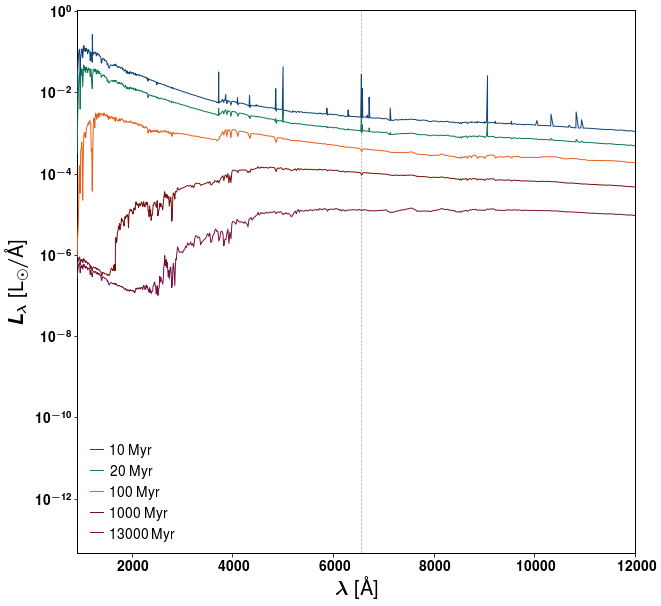

In [5]:
SEDs_tot.get(["10 Myr","20 Myr","100 Myr","1000 Myr", "13000 Myr"]).plot(lw=1.0, zorder=999)
ax = gca()
ax.axvline(6562, lw=0.75, ls="--", color="0.7")
ax.set_xlim(912,12000)
ax.set_yscale("log")
ax.set_xlabel(r"$\lambda$ [\AA]")
ax.set_ylabel(r"$L_\lambda$ [L$_{\odot}/$\AA]")

In [6]:
# First Approach to the colour-EW correlation
# In rest-frame, compute the SDSS colours
ur_neb = zeros(ages.size)
ur_ste = zeros(ages.size)
ew_neb = zeros(ages.size)
for j in xrange(ages.size):
    SED_neb_j = column_stack((SEDs_tot.index.values,SEDs_tot.get(SEDs_tot.columns[j])))
    SED_ste_j = column_stack((SEDs_ste.index.values,SEDs_ste.get(SEDs_ste.columns[j])))
    
    ur_neb[j] = integrated_flux(SED_neb_j, sdss_res[0]) - integrated_flux(SED_neb_j, sdss_res[2])
    ur_ste[j] = integrated_flux(SED_ste_j, sdss_res[0]) - integrated_flux(SED_ste_j, sdss_res[2])
    ew_neb[j] = equivalent_width(SED_neb_j, (6562,), (40,))[0]
# Compute the colour excess
ur_excess = ur_ste - ur_neb

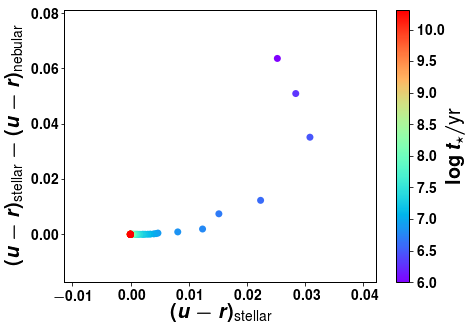

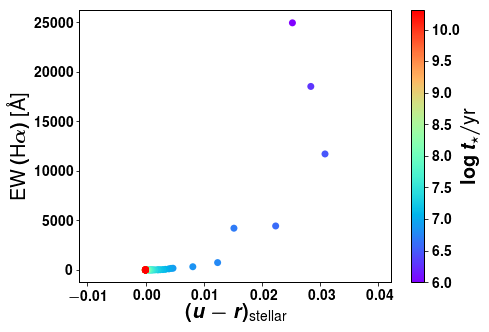

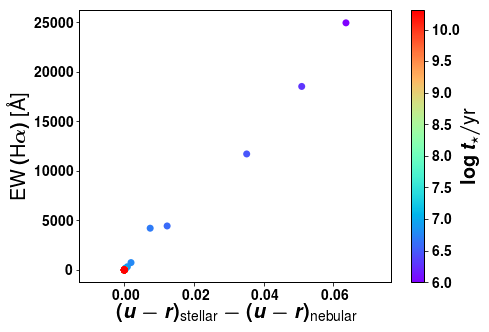

In [7]:
# Plot the colour vs the colour-excess (this should show an anti-correlation)
figure(figsize=(7,5))
scatter(ur_ste, ur_excess, c=log10(ages.values), lw=0, cmap=cm.rainbow)
cb = colorbar()
xlabel(r"$(u-r)_\text{stellar}$")
ylabel(r"$(u-r)_\text{stellar}-(u-r)_\text{nebular}$")
cb.set_label(r"$\log{t_\star/\text{yr}}$")

figure(figsize=(7,5))
scatter(ur_ste, ew_neb, c=log10(ages.values), lw=0, cmap=cm.rainbow)
cb = colorbar()
xlabel(r"$(u-r)_\text{stellar}$")
ylabel(r"$\text{EW}\,(\text{H}\alpha)$ [\AA]")
cb.set_label(r"$\log{t_\star/\text{yr}}$")

figure(figsize=(7,5))
scatter(ur_excess, ew_neb, c=log10(ages.values), lw=0, cmap=cm.rainbow)
cb = colorbar()
xlabel(r"$(u-r)_\text{stellar}-(u-r)_\text{nebular}$")
ylabel(r"$\text{EW}\,(\text{H}\alpha)$ [\AA]")
cb.set_label(r"$\log{t_\star/\text{yr}}$")

# This will help separate the age-nebular emission relation

In [8]:
# NEXT STEPS

# simulate redshift sample
z_in, z_fi = 0.001, 0.2
redshift = z_in + random.rand(10000)*(z_fi-z_in)
# define probability distribution for redshift assignment according to age(~mass~colour)
PDF_age = lambda t, z: exp((0.5*z+0.05)*t)
# simulate SDSS photometry for that sample using:
#    SEDs with nebular emission
#    SEDs with pure stellar emission
ur_neb_z = zeros(redshift.size)
ur_ste_z = zeros(redshift.size)
ew_neb_z = zeros(redshift.size)
ages_z = zeros(redshift.size)
for j,z in enumerate(redshift):
    weights = PDF_age(log10(ages.values), z)
    weights /= weights.sum()
    i = random.choice(ages.index, p=weights)
    
    SED_neb_z = column_stack((SEDs_tot.index.values*(z+1),SEDs_tot.get(SEDs_tot.columns[i])))
    SED_ste_z = column_stack((SEDs_ste.index.values*(z+1),SEDs_ste.get(SEDs_ste.columns[i])))
    
    ages_z[j] = log10(ages.get(i))
    ur_neb_z[j] = integrated_flux(SED_neb_z, sdss_res[0]) - integrated_flux(SED_neb_z, sdss_res[2])
    ur_ste_z[j] = integrated_flux(SED_ste_z, sdss_res[0]) - integrated_flux(SED_ste_z, sdss_res[2])
    ew_neb_z[j] = equivalent_width(SED_neb_z, (6562*(z+1),), (40*(z+1),))[0]

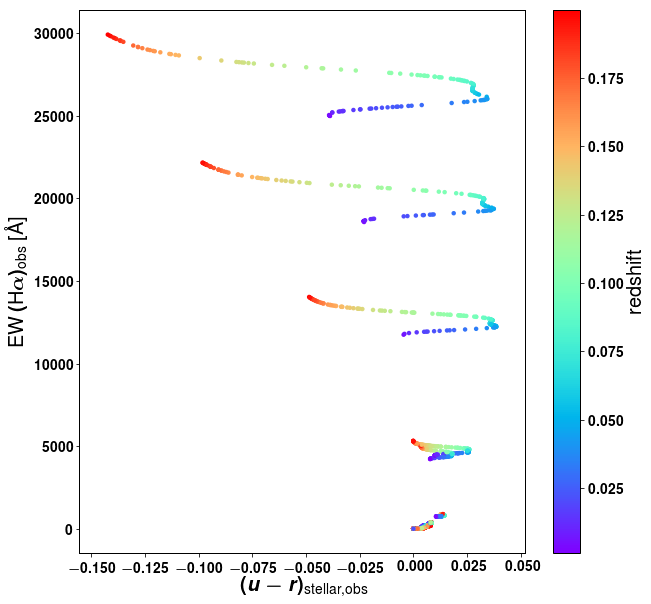

In [9]:
# plot colour vs colour excess (stellar - nebular) vs redshift
scatter(ur_neb_z, ew_neb_z, c=redshift, s=20, lw=0, cmap=cm.rainbow)
cb = colorbar()
xlabel(r"$(u-r)_\text{stellar,obs}$")
ylabel(r"$\text{EW}\,(\text{H}\alpha)_\text{obs}$ [\AA]")
cb.set_label(r"$\text{redshift}$")
# show surveys sample selection cuts (e.g., r<17.7)